<h1 style='color: yellow'> Metric Generator </h1>

Generates all the ToE metrics

In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple
from time import sleep, time
from glob import glob
from pathlib import Path
# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import xarray as xr
import dask
from scipy.stats import spearmanr
# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import constants
import utils
import plotting_utils
import climate_utils
import stats
import diagnostic_tools
import paths

import time_of_emergence_calc as toe_calc
import time_of_emergence_data_analysis as toe_da
import toe_constants as toe_const
import open_data
from toe_constants import PVALUE_THESHOLD1, OVERLAP_THRESHOLD, SN_THRESHOLD1
import time_of_emergence_plots
import toe_constants as toe_const
import plotting_utils
import misc
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

Matplotlib created a temporary cache directory at /jobfs/132364260.gadi-pbs/matplotlib-qzgi1bkx because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
xr.set_options(display_expand_data=False)

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.function_base')

In [4]:
# import matplotlib.pylab as pylab
# pylab.rcParams.update({'axes.labelsize':20, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'figure.figsize': [12, 6]})

In [5]:
# client.close()

In [6]:
from dask.distributed import Client, wait
# # client = Client(threads_per_worker=1, n_workers=20)
# client.close()
client = Client(n_workers=12, threads_per_worker=1, memory_limit=None) 
client

 - State start
 - Found stale lock file and directory '/jobfs/132364260.gadi-pbs/dask-scratch-space/scheduler-hje546tg', purging
 -   Scheduler at:     tcp://127.0.0.1:32927
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:35117'
 -         Start Nanny at: 'tcp://127.0.0.1:41631'
 -         Start Nanny at: 'tcp://127.0.0.1:35999'
 -         Start Nanny at: 'tcp://127.0.0.1:39453'
 -         Start Nanny at: 'tcp://127.0.0.1:41659'
 -         Start Nanny at: 'tcp://127.0.0.1:34703'
 -         Start Nanny at: 'tcp://127.0.0.1:42789'
 -         Start Nanny at: 'tcp://127.0.0.1:44711'
 -         Start Nanny at: 'tcp://127.0.0.1:45127'
 -         Start Nanny at: 'tcp://127.0.0.1:33645'
 -         Start Nanny at: 'tcp://127.0.0.1:41321'
 -         Start Nanny at: 'tcp://127.0.0.1:41091'
 - Register worker <WorkerState 'tcp://127.0.0.1:40715', name: 10, status: init, memory: 0, processing: 0>
 - Starting worker compu

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32927,Workers: 12
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46527,Total threads: 1
Dashboard: /proxy/35743/status,Memory: 0 B
Nanny: tcp://127.0.0.1:35117,


 - Detected different `run_spec` for key ('getitem-06986beb3b4e33779793179afa882206', 0, 5, 2) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
                         Debugging information
                         ---------------------
                         old task state: waiting
                         old run_spec: (<function getitem at 0x1467df125360>, (('getitem-b9cc63dde2f4987e3b60f7a83de64f61', 0, 5, 2), (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), slice(None, None, None), slice(None, None, None))), {})
                         new run_spec: (<function execute_task at 0x1467d161b760>, (('open_dataset-getitem-0

In [7]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

<h1 style='color:yellow'> Opening Data </h1>

<h2 style='color:cyan'> Data Funcions </h2>

In [8]:
reload(open_data)

<module 'open_data' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/open_data.py'>

In [9]:
# data_ds = open_data.open_best()
# chunks = open_data.best_chunks

# # data_ds = open_data.open_gpcc(resample='QS-DEC')
# # Precip variables must have extra selections
# # data_ds = data_ds.sel(time=data_ds.time.dt.month==12)

In [10]:
# from glob import glob
# var = 'tmax'
# path = f'/g/data/rt52/era5/single-levels/reanalysis/{var}/*/*.nc'
# files_to_open = glob(path, recursive=True)
# print(len(files_to_open))
# td = xr.open_dataset(files_to_open[-30])

In [11]:
# resample = 'QS-JUN'#'QS-DEC' # 'YE'
# chunks = open_data.CHUNKS['access']['small']

# data_ds = open_data.open_access(
#     variable='pr',
#     ensemble='r10i1p1f1',
#     scenario='ssp585',
#     resample=resample
# ).chunk(chunks).isel(time=slice(1, None))

In [12]:
# import paths
# np.array(os.listdir(paths.ERA5_PATH))

In [13]:
# # Potential era5 variables - cape, skt (skin temperature), smlt (snow melt)
# # data_ds = open_data.open_era5('tmax', resample_method='max', save=True).isel(time=slice(None, -1))
# chunks = open_data.ERA5_CHUNKS #ERA5_SMALL_CHUNKS
# data_ds = open_data.open_era5(
#     't2m',
#     return_raw = False,
#     save = True,
#     resample_method = "sum",
#     logginglevel='INFO',
#     chunks = chunks,
# )
# data_ds = data_ds.isel(time=slice(None, -1))
# # data_das = open_data.open_era5_reanalysis('tmax') # Only use this if saving. Otherwise use open_era5

In [14]:
# data_ds

<h2 style='color: cyan'> ERA5 Resample (large data) </h2>

In [15]:
# np.array(os.listdir('/g/data/rt52/era5/single-levels'))
# np.array(os.listdir('/g/data/rt52/era5/single-levels/monthly-averaged'))

In [16]:
var = '2t'
var_name = var
path = f'/g/data/rt52/era5/single-levels/reanalysis/{var}'

MY_ERA5_PATH = os.path.join(paths.DATA_DIR, 'era5')
output_file = Path(os.path.join(MY_ERA5_PATH, f"{var_name}.zarr"))

In [17]:
# client.cluster.scale(100)
# sleep(6)
# def __preprocess(ds):
#     return ds.to_array().rename({'latitude': 'lat', 'longitude': 'lon'})
# wild_tag = '*/*.nc'
# years = np.sort(os.listdir(path))
# files_to_open = glob(os.path.join(path, wild_tag), recursive=True)

# for i, year in enumerate(years):
#     print(f'{year}, ', end='')
#     year_file = np.sort([f for f in files_to_open if year in f.split('/')[-2]])
#     # print(year_file)
#     da_raw = xr.open_mfdataset(
#         year_file,
#         use_cftime=True,
#         chunks = {'time': -1, 'lon': 1440//240, 'lat':731//103},
#         preprocess = __preprocess
#     )

#     da = da_raw.resample(time='Y').mean().compute()

#     da = da.squeeze("variable", drop=True)
#     da.name = var_name

#     da.attrs['method'] = 'Resampled from hourly to yearly mean'
    
#     # Save to Zarr
#     if i == 0:
#         # First year: Create the Zarr file
#         da.to_zarr(output_file, mode="w", consolidated=True)
#         print(f"Saved {year} to {output_file}")
#     else:
#         # Subsequent years: Append to the Zarr file
#         da.to_zarr(output_file, mode="a", append_dim="time")
#         print(f"Appended {year} to {output_file}")

In [18]:
# data_ds = xr.open_zarr(str(output_file).replace(var, var+'_tmp'), use_cftime=True).to_array().compute().chunk(chunks=chunks)
# data_ds.attrs['save_chunks'] = chunks
# data_ds = data_ds.squeeze('variable', drop=True)
# data_ds.name = var
# data_ds.to_zarr(output_file)

In [19]:
chunks = open_data.ERA5_CHUNKS #ERA5_SMALL_CHUNKS
data_ds = xr.open_zarr(str(output_file), chunks=chunks)[var]

In [20]:
data_ds

<xarray.DataArray '2t' (time: 85, lat: 721, lon: 1440)> Size: 706MB
dask.array<open_dataset-2t, shape=(85, 721, 1440), dtype=float64, chunksize=(85, 120, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 680B 1940-12-31 1941-12-31 ... 2024-12-31
Attributes: (1)

In [21]:
# data_ds_raw = xr.open_mfdataset(
#     files_to_open,
#     combine="by_coords",
#     parallel=True,
#     chunks={'time': -1, 'lon': 1440//240, 'lat':731//103} ,
#     use_cftime=True,
# )

# # Rename dimensions and re-chunk for efficiency
# data_ds_raw = data_ds_raw.rename({'latitude': 'lat', 'longitude': 'lon'})

# data_ds_resample = data_ds_raw.to_array().resample(time='YE').mean()

# data_ds_resample = data_ds_resample.compute()

# import paths
# MY_ERA5_PATH = os.path.join(paths.DATA_DIR, 'era5')
# SAVE_NAME = os.path.join(MY_ERA5_PATH, f'{var}.zarr')
# data_ds_resample.to_zarr(SAVE_NAME, mode='w')

<h2 style='color:cyan'> Data Check </h2>

In [22]:
chunks

{'time': -1, 'lat': 120, 'lon': 120}

In [23]:
data_ds

<xarray.DataArray '2t' (time: 85, lat: 721, lon: 1440)> Size: 706MB
dask.array<open_dataset-2t, shape=(85, 721, 1440), dtype=float64, chunksize=(85, 120, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 680B 1940-12-31 1941-12-31 ... 2024-12-31
Attributes: (1)

In [24]:
assert len(data_ds.chunksizes['time']) == 1

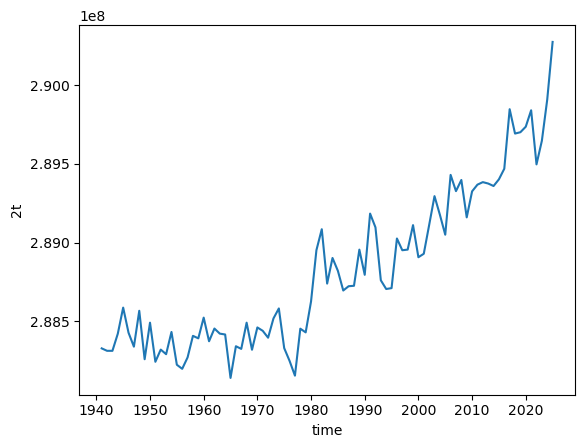

In [25]:
# data_ds.mean(dim=['lat', 'lon']).plot()
data_ds.sum(dim=['lat', 'lon']).plot()

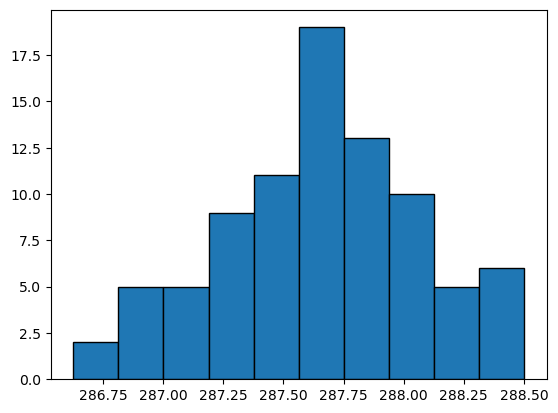

In [26]:
plt.hist(data_ds.sel(lat=-38, lon=145, method='nearest').squeeze().values, edgecolor='k');

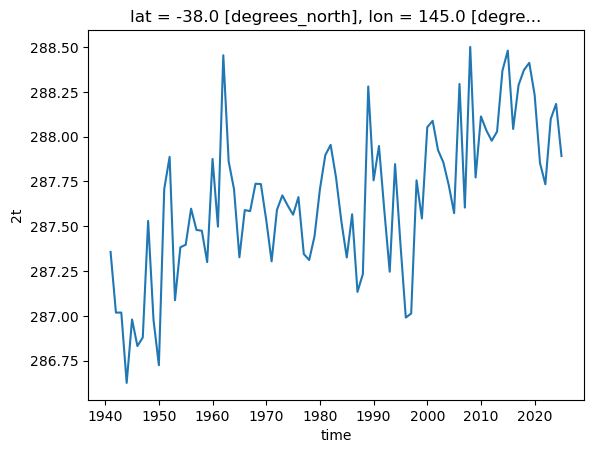

In [27]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot()

In [28]:
t_start = time()

In [29]:
print(np.array(toe_const.YearRange))

[<YearRange.MODERN_PERIOD: (1959, 1989)>
 <YearRange.MID_20TH_CENTURY: (1929, 1959)>
 <YearRange.EARLY_20TH_CENTURY: (1899, 1929)>
 <YearRange.ERA5_START: (1940, 1970)>]


In [30]:
# Create a data set for the base period used as the pre-industrial climate 
# base_period = #(1959, 1989)#(1900, 1950)#(1900, 1931)
base_period = toe_const.YearRange.MODERN_PERIOD
base_period, base_period.start, base_period.end

(<YearRange.MODERN_PERIOD: (1959, 1989)>, 1959, 1989)

In [31]:
resample_stamp = data_ds.attrs.get('resample', None)
if resample_stamp: resample_stamp = resample_stamp.replace('-', '')
resample_stamp

In [ ]:
dataset_name, variable =   'era5', var #data_ds.dataset_name, data_ds.name
dataset_name, variable

In [ ]:
# Specific chunks for era5
# if 'era5' in dataset_name: data_ds = data_ds.compute().chunk(open_data.ERA5_SMALL_CHUNKS)

In [ ]:
os.listdir(constants.TOE_SAVE_DIR)

In [ ]:
VAR_SAVE_DIR = os.path.join(
    constants.TOE_SAVE_DIR, f'{dataset_name}_{variable}')
                            
if resample_stamp:
    VAR_SAVE_DIR += f'_{resample_stamp}'

VAR_SAVE_DIR += f'_({base_period.start}_{base_period.end})'
VAR_SAVE_DIR

In [36]:
# os.makedirs(VAR_SAVE_DIR, exist_ok=True)
# I actually do want error if already exists
# os.rmdir(VAR_SAVE_DIR)
os.makedirs(VAR_SAVE_DIR, exist_ok=True)

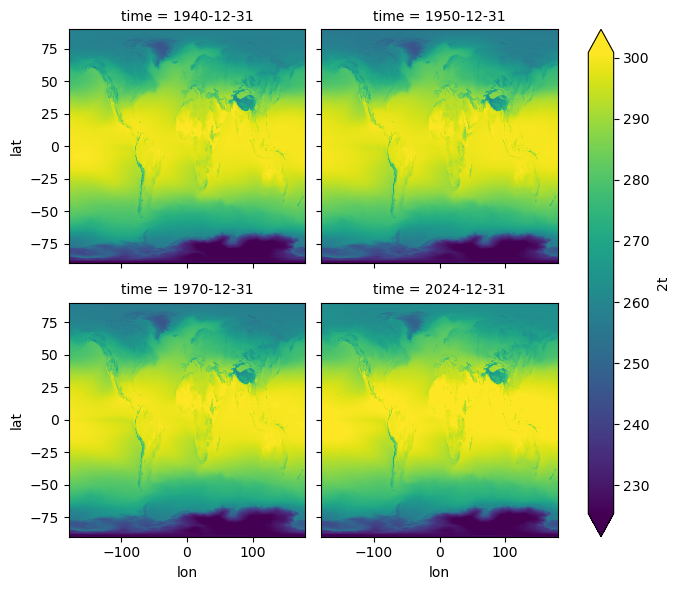

In [37]:
data_ds.isel(time=[0, 10, 30, -1]).plot(col='time', col_wrap=2, robust=True)

In [38]:
len(data_ds.time.values), np.take(data_ds.time.values, [0, 1,2, -3, -2, -1])

(85,
 array(['1940-12-31T00:00:00.000000000', '1941-12-31T00:00:00.000000000',
        '1942-12-31T00:00:00.000000000', '2022-12-31T00:00:00.000000000',
        '2023-12-31T00:00:00.000000000', '2024-12-31T00:00:00.000000000'],
       dtype='datetime64[ns]'))

In [39]:
# Calculate statistics
min_val = data_ds.min().values.item()
q25_val = data_ds.reduce(np.nanpercentile, q=25).values.item()
q75_val = data_ds.reduce(np.nanpercentile, q=75).values.item()
max_val = data_ds.max().values.item()

# Display nicely
print(f"Statistics:\n"
      f"Min: {min_val:.2f}\n"
      f"25th Percentile: {q25_val:.2f}\n"
      f"75th Percentile: {q75_val:.2f}\n"
      f"Max: {max_val:.2f}")


Statistics:
Min: 214.99
25th Percentile: 264.66
75th Percentile: 295.84
Max: 308.66


In [40]:
# Remove data that occurs before this
data_ds = data_ds.sel(time=data_ds.time.dt.year>=base_period.start)
data_ds

<xarray.DataArray '2t' (time: 66, lat: 721, lon: 1440)> Size: 548MB
dask.array<getitem, shape=(66, 721, 1440), dtype=float64, chunksize=(66, 120, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 528B 1959-12-31 1960-12-31 ... 2024-12-31
Attributes: (1)

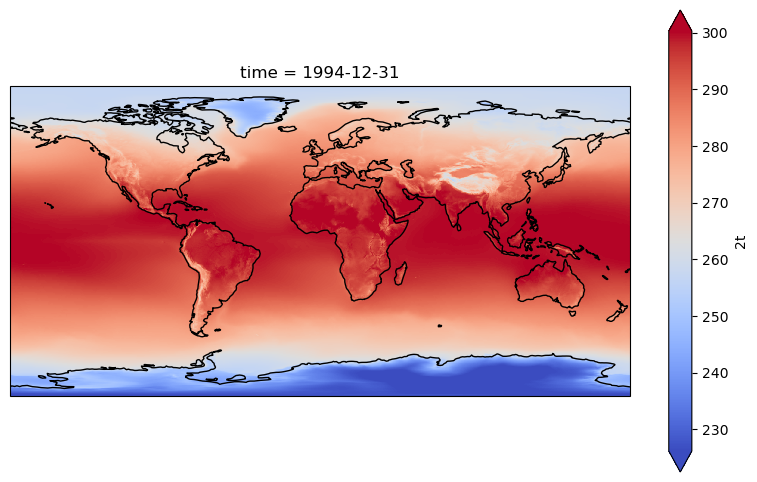

In [41]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_ds.isel(time=35).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

In [42]:
base_period_ds = data_ds.where(data_ds.time.dt.year.isin(np.arange(*base_period.value)), drop=True)
base_period_ds

<xarray.DataArray '2t' (time: 30, lat: 721, lon: 1440)> Size: 249MB
dask.array<where, shape=(30, 721, 1440), dtype=float64, chunksize=(30, 120, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 240B 1959-12-31 1960-12-31 ... 1988-12-31
Attributes: (1)

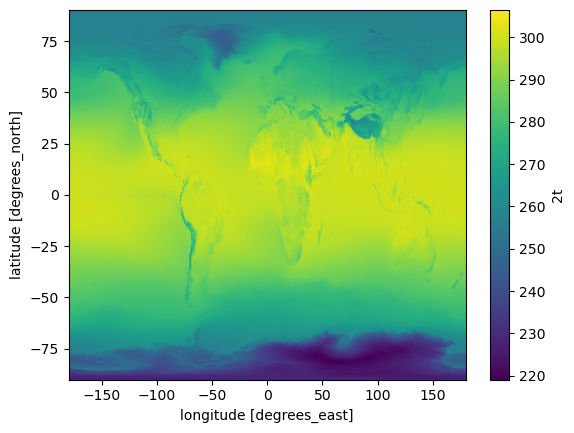

In [43]:
base_period_ds.mean(dim='time').plot()

In [44]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
base_period_ds_count = base_period_ds.count(dim='time')
# How many years are needed for 80 percent
percent_80_of_years = 0.8*(base_period.end - base_period.start)
data_availability_mask = xr.where(base_period_ds_count>=percent_80_of_years, 1, 0)
data_availability_mask

<xarray.DataArray '2t' (lat: 721, lon: 1440)> Size: 8MB
dask.array<where, shape=(721, 1440), dtype=int64, chunksize=(120, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

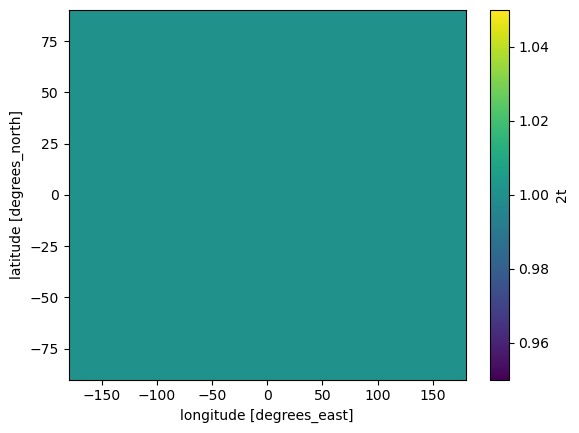

In [45]:
data_availability_mask.plot()

In [46]:
# Apply the mask to both the base period and the full dataset
data_ds = data_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [47]:
# Resetting the anomlies to 1850
data_ds = data_ds - base_period_ds.mean(dim='time')
base_period_ds = base_period_ds - base_period_ds.mean(dim='time')

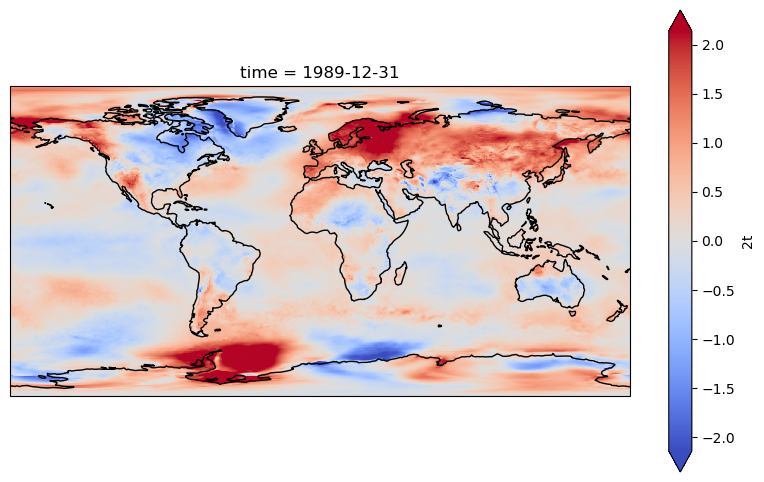

In [48]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_ds.isel(time=30).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

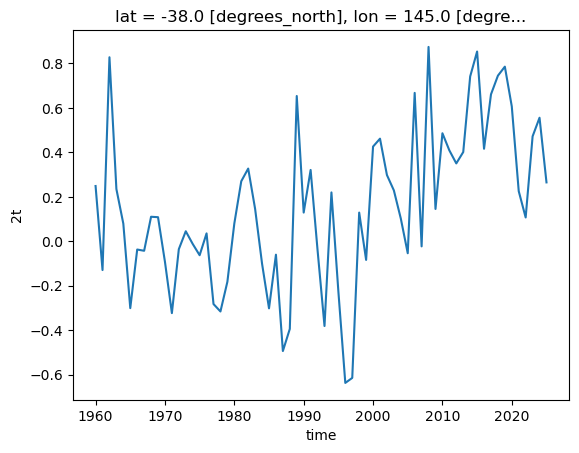

In [49]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot()

<h1 style='color: yellow'> Metric Calculation </h1>

<h2 style='color: cyan'>Dataset set-up </h2>

<ul>
    <li> Scaling client</li>
    <li> Chunking data set</li>
</ul>

In [50]:
window = 30

In [51]:
CHUNKS_FOR_PVALUE_TESTS = chunks.copy()
CHUNKS_FOR_PVALUE_TESTS['lat'] = chunks['lat']/2# * 2
CHUNKS_FOR_PVALUE_TESTS

{'time': -1, 'lat': 60.0, 'lon': 120}

In [52]:
data_ds_window = (data_ds
                  .chunk(CHUNKS_FOR_PVALUE_TESTS)
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .persist()
                 ) 

base_period_window_ds = (base_period_ds
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )

In [53]:
# CHUNKS_FOR_PVALUE_TESTS =  {'lat':30, 'lon':30, 'time':-1}
# CHUNKS_FOR_PVALUE_TESTS = {**chunks, **{'window_dim':-1}}
# CHUNKS_FOR_PVALUE_TESTS =  {'lat':60, 'lon':30, 'time':-1}
# CHUNKS_FOR_PVALUE_TESTS =  {'lat':60, 'lon':30, 'time':-1}

In [54]:
# # Creting new datasets that has windown dimnsion for the rolling calculation
# data_ds_window = (
#     data_ds
#   .persist()
#   .rolling(time=window, center=True, min_periods=window)
#   .construct('window_dim')
#   .persist()
#   .chunk(CHUNKS_FOR_PVALUE_TESTS)
# )

# base_period_window_ds = (
#     base_period_ds
#     .rename({'time':'window_dim'})
#     .persist()
#     .chunk(
#         **{key: CHUNKS_FOR_PVALUE_TESTS[key] for key in ['lat', 'lon', 'window_dim']
#            if key in CHUNKS_FOR_PVALUE_TESTS})
# ) 

In [57]:
wait(data_ds_window);
wait(base_period_window_ds);

In [58]:
base_period_window_ds

<xarray.DataArray '2t' (window_dim: 30, lat: 721, lon: 1440)> Size: 249MB
dask.array<rechunk-merge, shape=(30, 721, 1440), dtype=float64, chunksize=(30, 60, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon         (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * window_dim  (window_dim) datetime64[ns] 240B 1959-12-31 ... 1988-12-31

In [59]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [60]:
# # P-value methods works better with a large cluster.
# # Small chunks with large computation
client.cluster.scale(100);
sleep(7);

 -         Start Nanny at: 'tcp://127.0.0.1:35131'
 -         Start Nanny at: 'tcp://127.0.0.1:33533'
 -         Start Nanny at: 'tcp://127.0.0.1:42741'
 -         Start Nanny at: 'tcp://127.0.0.1:46119'
 -         Start Nanny at: 'tcp://127.0.0.1:45097'
 -         Start Nanny at: 'tcp://127.0.0.1:38755'
 -         Start Nanny at: 'tcp://127.0.0.1:32971'
 -         Start Nanny at: 'tcp://127.0.0.1:36833'
 -         Start Nanny at: 'tcp://127.0.0.1:44857'
 -         Start Nanny at: 'tcp://127.0.0.1:39279'
 -         Start Nanny at: 'tcp://127.0.0.1:34003'
 -         Start Nanny at: 'tcp://127.0.0.1:42153'
 -         Start Nanny at: 'tcp://127.0.0.1:37365'
 -         Start Nanny at: 'tcp://127.0.0.1:41305'
 -         Start Nanny at: 'tcp://127.0.0.1:36159'
 -         Start Nanny at: 'tcp://127.0.0.1:46611'
 -         Start Nanny at: 'tcp://127.0.0.1:34301'
 -         Start Nanny at: 'tcp://127.0.0.1:37597'
 -         Start Nanny at: 'tcp://127.0.0.1:39957'
 -         Start Nanny at: 'tcp

<h2 style='color: cyan'> Overlap Methods </h2>

In [63]:
kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)

# Optimized

### Perkins

In [61]:
data_arr = data_ds.values.flatten()
data_arr = data_arr[data_arr != 0]

In [62]:
bins = toe_calc.calculate_freedman_diaconis_bins(data_arr, length=len(data_ds.time.values),
                                                logginglevel='DEBUG')

np.unique(np.diff(bins).round(2)).item(), bins

p75=0.7486973600983475, p25=-0.11346999222989496, iqr=0.8621673523282425, length=66
 - 0.4266845561900097


(0.43,
 array([-7.52, -7.09, -6.66, -6.24, -5.81, -5.38, -4.96, -4.53, -4.1 ,
        -3.68, -3.25, -2.82, -2.4 , -1.97, -1.54, -1.12, -0.69, -0.26,
         0.16,  0.59,  1.02,  1.45,  1.87,  2.3 ,  2.73,  3.15,  3.58,
         4.01,  4.43,  4.86,  5.29,  5.71,  6.14,  6.57,  6.99,  7.42,
         7.85,  8.27,  8.7 ,  9.13]))

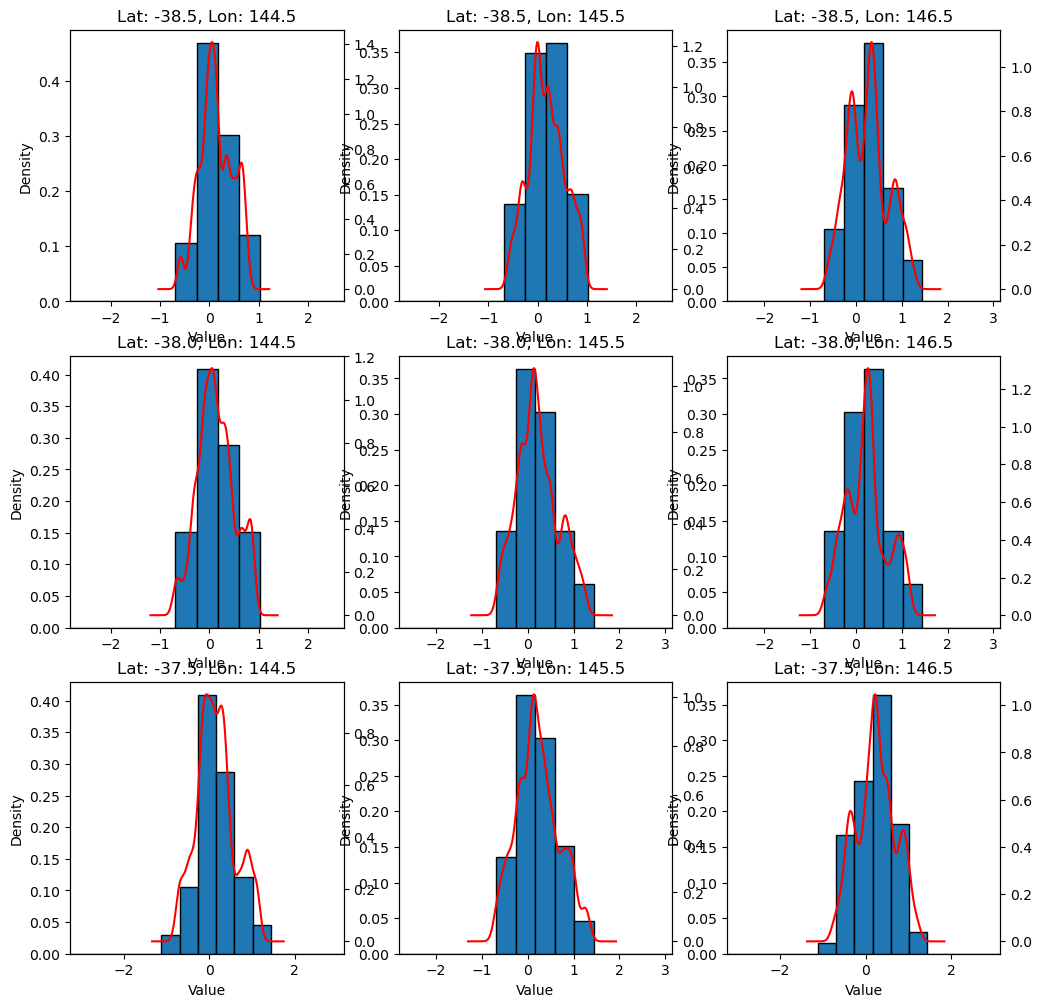

In [66]:
# Example latitudes and longitudes range (adjust as needed)
lats = np.linspace(-38.5, -37.5, 3)  # Replace with your actual latitudes
lons = np.linspace(144.5, 146.5, 3)  # Replace with your actual longitudes

# Create a 3x3 plot grid
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Loop through latitudes and longitudes
for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        # Extract the data for the current lat, lon
        test_data = data_ds.sel(lat=lat, lon=lon, method='nearest').values
        
        # Compute the KDE
        _, rel_freq = toe_calc.discrete_pdf(test_data, bins=bins)
        x_test, kde_test = toe_calc.create_kde(test_data, **kde_kwargs)

        # Plot on the current subplot
        ax = axs[i, j]
        ax2 = ax.twinx()
        ax.bar(bins[:-1], rel_freq, width=np.diff(bins), align='edge', edgecolor='k')
        ax2.plot(x_test, kde_test, color='r')
        ax.set_title(f'Lat: {lat}, Lon: {lon}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        valid_bins = bins[:-1][rel_freq > 0]
        x_min, x_max = valid_bins.min()-5*np.diff(bins)[0], valid_bins.max()+5*np.diff(bins)[0]
        ax.set_xlim(x_min, x_max)

In [67]:
%%time
# Pre-calculate the relative frequency of the base period

base_period_rel_freq_ds = xr.apply_ufunc(
    toe_calc.get_rel_freq,
    base_period_ds,
    input_core_dims=[['time']],
    output_core_dims=[['bins']],
    kwargs={'bins': bins},
    vectorize=True,
    dask='parallelized',
    output_sizes={'bins': len(bins) - 1}, 
    output_dtypes=float
).persist()
wait(base_period_rel_freq_ds)

CPU times: user 49.4 ms, sys: 2.52 ms, total: 51.9 ms
Wall time: 49.7 ms


In [68]:
%%time
perkins_ds = xr.apply_ufunc(
    toe_calc.perkins_skill_score_base_bins,
    data_ds_window,
    base_period_rel_freq_ds,
    kwargs={'bins': bins},
    input_core_dims=[['window_dim'], ['bins']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
    ).compute()

CPU times: user 15.6 s, sys: 6.72 s, total: 22.3 s
Wall time: 34.4 s


In [69]:
perkins_ds = perkins_ds.sortby('lat')

In [107]:
perkins_ds.attrs = {
    'window': window,
    **perkins_ds.attrs,
    'bins': 
    {
        'start':bins.round(4)[0],
        'stop':bins.round(4)[-1],
        'step': np.unique(np.diff(bins)).round(4)[0]}
}

In [71]:
location = dict(lat=69, lon=-165, method='nearest')

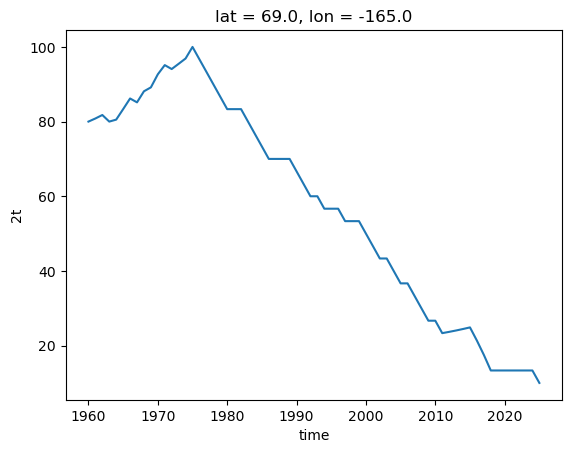

In [82]:
perkins_ds.sel(**location).plot()

In [78]:
base_arr = base_period_ds.sel(**location).values
rel_freq_base = toe_calc.rel_freq(base_arr, bins)
future_arr = data_ds.sel(**location).where(
    data_ds.time.dt.year.isin(np.arange(base_period.start, base_period.start+window)), drop=True).values
rel_freq_future = toe_calc.rel_freq(future_arr, bins=bins)

In [79]:
toe_calc.discrete_distribution_overlap(rel_freq_base, rel_freq_future),\
toe_calc.perkins_skill_score(future_arr, base_arr, bins=bins),\
perkins_ds.sel(**location).isel(time=10).values.item()

(100.0, 100.0, 92.66666666666667)

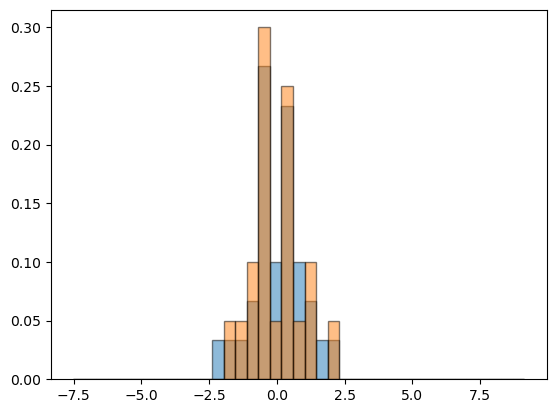

In [74]:
fig, ax = plt.subplots(1, 1)
diagnostic_tools.plot_bar(bins, rel_freq_base, ax=ax)
diagnostic_tools.plot_bar(bins, rel_freq_future, ax=ax)

In [75]:
toe_calc.perkins_skill_score_base_bins(
    data_ds_window.sel(lat=-39, lon=145,method='nearest').isel(time=slice(None, 30)).values,
    base_period_rel_freq_ds.sel(lat=-39, lon=145,method='nearest').values,
    bins=bins
)

93.97435897435898

<BarContainer object of 39 artists>

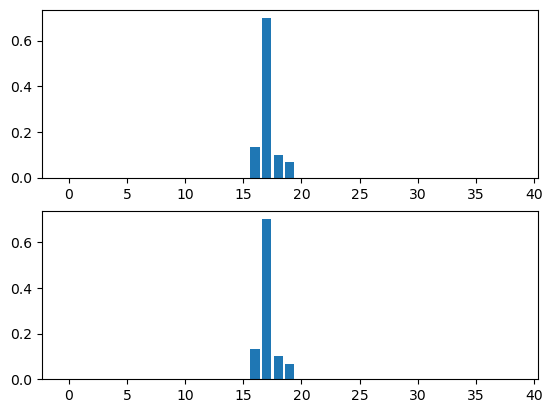

In [76]:
fig, (ax1, ax2) = plt.subplots(2, 1)

test_loc = dict(lat=-39, lon=145, method='nearest')
rel_freq_test = toe_calc.get_rel_freq(base_period_ds.sel(**test_loc).squeeze().values, bins=bins)

ax1.bar(base_period_rel_freq_ds.bins.values, rel_freq_test)
ax2.bar(base_period_rel_freq_ds.bins.values, base_period_rel_freq_ds.sel(**test_loc).values)

 - locator: <matplotlib.ticker.FixedLocator object at 0x1462b94644c0>


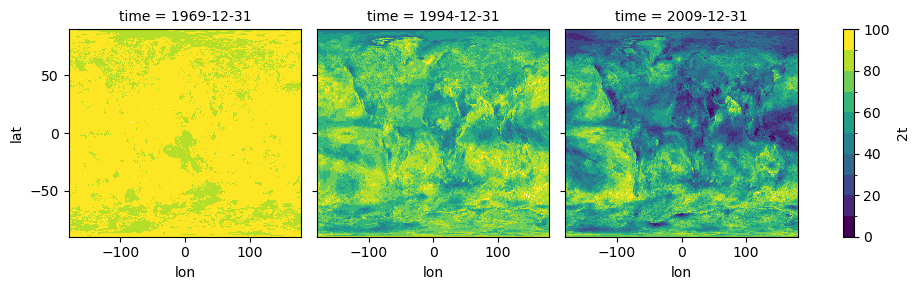

In [92]:
perkins_ds.isel(time=[10, 35, 50]).plot(col='time', levels=np.arange(0, 110, 10))

### KDE Metrics

In [83]:
def create_kde_x_exists(arr: np.ndarray, x: np.ndarray, **kwargs):
    """
    Create a KDE for the given array and evaluate it at the specified points.

    Parameters:
    - arr: np.ndarray, input data for KDE computation.
    - x: np.ndarray, points at which to evaluate the KDE.
    - kwargs: Additional arguments to pass to scipy.stats.gaussian_kde.

    Returns:
    - kde_vals: np.ndarray, normalized KDE values evaluated at `x`.
    """
    # Remove NaN and infinite values from the array
    arr = arr[np.isfinite(arr)]
    
    # Compute the KDE
    kde = toe_calc.gaussian_kde(arr, **kwargs)
    kde_vals = kde(x)

    # Normalize the KDE values to ensure total area equals 1
    kde_vals /= np.trapz(kde_vals, x)

    return kde_vals


In [84]:
def calculate_kde_overlap(dist1, dist2, x):
    """
    Calculate the percentage overlap between two probability density functions (KDEs).
    
    Parameters:
    - dist1: array-like, first KDE values evaluated on x.
    - dist2: array-like, second KDE values evaluated on x.
    - x: array-like, the points where dist1 and dist2 are evaluated.
    
    Returns:
    - overlap_percent: float, percentage overlap between the two distributions.
    """
    # Calculate the overlap shape by taking the minimum of the two KDEs at each point
    overlap_shape = np.minimum(dist1, dist2)
    
    # Integrate the overlap shape to find the overlap area
    overlap_area = np.trapz(overlap_shape, x)
    
    # Convert the overlap area to a percentage (assuming KDEs are normalized)
    overlap_percent = overlap_area * 100

    return overlap_percent


In [85]:
def __overlap_helper_function_base_fitted(
    arr_future: np.ndarray, kde_base: np.ndarray,
    overlap_function, x, method_kwargs=None) -> float:
    """
    Helper function to calculate the overlap between the KDEs of two arrays using a specified overlap function.

    Parameters:
    arr_future (numpy.ndarray): First input array of values.
    arr_base (numpy.ndarray): Second input array of values.
    return_all (bool): If False (default) just return the overlap percent. If True,
                        return the KDEs and the overlap percent.
    kde_kwargs (dict, optional): Keyword arguments to pass to the KDE creation function.
    bmax (float, optional): Maximum value for the range of the KDE.
    bmin (float, optional): Minimum value for the range of the KDE.
    overlap_function (callable, optional): Function to calculate overlap between two distributions.
                                           Should accept `kde_base`, `kde_future`, and `x` as arguments.

    Returns:
    float: Overlap area as calculated by the specified overlap function. Returns NaN if any array is fully NaN.
    """
    if not method_kwargs: method_kwargs = {}

    # Check if any input array is fully NaN
    if np.all(np.isnan(arr_future)): return np.nan

    kde_future = create_kde_x_exists(arr_future, x, **method_kwargs)
    # print(kde_future == kde_base)
    
    out_metric = overlap_function(kde_base, kde_future, x)
    return out_metric

In [126]:
# The x-values for the KDE are based upon the max and min
data_max = data_ds.max().persist().values.item()
data_min = data_ds.min().persist().values.item()
num_points = 1000
x = toe_calc.create_x(bmin=data_min, bmax=data_max, num_points=num_points)

data_min, data_max, x.shape

(-7.515343174178895, 9.030853681423707, (1000,))

In [87]:
%%time
# Pre-calculate the base period KDE

base_period_kde = xr.apply_ufunc(
    create_kde_x_exists,
    base_period_ds,
    input_core_dims=[['time'], ],
    output_core_dims=[['x']],
    kwargs={'x': x, **kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_sizes={'x':len(x)},  # Specify the size of the 'bin' dimension
    output_dtypes=float
).persist()
wait(base_period_kde);

CPU times: user 5.07 s, sys: 1.58 s, total: 6.65 s
Wall time: 9.33 s


In [88]:
fractional_geometric_area_optimized = partial(
    __overlap_helper_function_base_fitted,
    overlap_function=calculate_kde_overlap)

In [89]:
hellinger_distance_optimized = partial(
    __overlap_helper_function_base_fitted,
    overlap_function=toe_calc.calculate_hellinger_distance)

In [90]:
%%time
hellinger_ds = xr.apply_ufunc(
    hellinger_distance_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()


CPU times: user 3min 14s, sys: 1min 23s, total: 4min 38s
Wall time: 7min 27s


In [91]:
%%time
frac_geom_ds = xr.apply_ufunc(
    fractional_geometric_area_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()
# wait(frac_geom_ds2)

CPU times: user 3min 16s, sys: 1min 24s, total: 4min 41s
Wall time: 7min 27s


In [127]:
x_attrs = { 'bmin': data_min, 'bmax':data_max, 'num_points': num_points}
frac_geom_ds.attrs = {'window': window,**frac_geom_ds.attrs, **kde_kwargs, **x_attrs}
hellinger_ds.attrs =  {'window': window, **hellinger_ds.attrs, **kde_kwargs, **x_attrs}

In [128]:
hellinger_ds.attrs

{'window': 30,
 'bw_method': 0.2,
 'bmin': -7.515343174178895,
 'bmax': 9.030853681423707,
 'num_points': 1000}

 - locator: <matplotlib.ticker.FixedLocator object at 0x1462b05befb0>


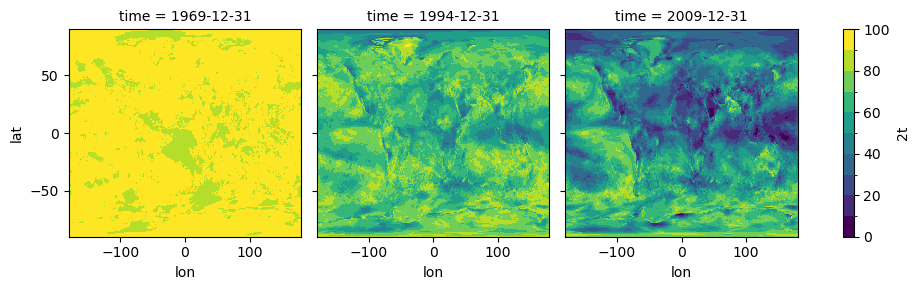

In [110]:
frac_geom_ds.isel(time=[10, 35, 50]).plot(col='time', levels=np.arange(0, 110, 10))

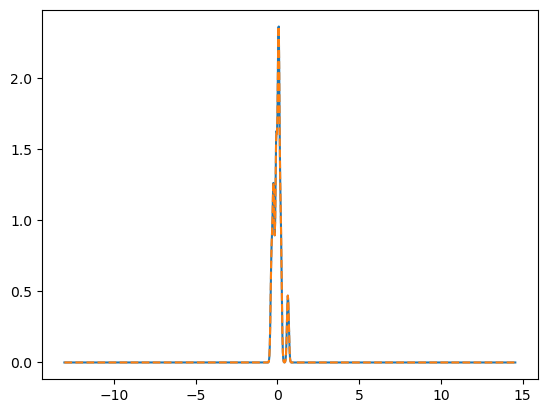

In [129]:
fig, ax1 = plt.subplots(1, 1)

test_loc = dict(lat=-39, lon=145, method='nearest')

test_kde = create_kde_x_exists(base_period_ds.sel(**test_loc).values, x, **kde_kwargs)

ax1.plot(x, base_period_kde.sel(**test_loc).values)
ax1.plot(x, test_kde, linestyle='--')

### Old - Ufunc

In [130]:
# %%time
# perkins_ds = xr.apply_ufunc(
#     toe_calc.perkins_skill_score,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs={'bins': bins},
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute().sortby('lat')

In [131]:
# %%time
# frac_geom_ds = xr.apply_ufunc(
#     toe_calc.fractional_geometric_area,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs = dict(method_kwargs=kde_kwargs),
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute()

In [132]:
# %%time
# hellinger_ds = xr.apply_ufunc(
#     toe_calc.hellinger_distance,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs = dict(method_kwargs=kde_kwargs),
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute()

<h2 style='color: cyan'> P-value Methods </h2>

1d Array Method <br>

This method comapes starting from the begging and looops through. The nans are added to the end so the length matches

In [133]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [134]:
# %%time
# Expected: 9 minutes 30 seconds
ttest_ds = xr.apply_ufunc(
        toe_calc.return_ttest_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

In [ ]:
%%time
# Expected 3 minutes 30 seconds - best
# 6 23 - era5
ks_ds = xr.apply_ufunc(
        toe_calc.return_ks_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
# ks_2samp will perfom on all nan slices
# ks_ds = ks_ds.where(data_availability_mask)

In [ ]:
# %%time
# anderson_ds = xr.apply_ufunc(
#     toe_calc.return_anderson_pvalue,
#     data_ds_window,
#     base_period_window_ds,
#     output_dtypes=float, 
#     **rolling_window_kwargs
#     ).compute()

### Verification of p-value test
- Comparison with 1d rolling func
Verifyting the abstracted (but faster) methods works by comparing to a single lat, lon point.

In [ ]:
lat_lon_sp = dict(lat=-34, lon=145, method='nearest')

In [ ]:
stats_test_1d_array_ks = partial(
    toe_calc.stats_test_1d_array, stats_func=toe_calc.return_ks_pvalue,
    window=window, base_period_length = base_period.end-base_period.start)

In [ ]:
ks_1d_1p = stats_test_1d_array_ks(data_ds.sel(**lat_lon_sp).values)

In [ ]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2))).values, label='roll', alpha=0.5)
plt.legend()

<h2 style='color: cyan'> Signal-to-Noise </h2>

<b> Hawkins S/N Ratio</b>

In [ ]:
# Calculate the wegithed mean
data_ds_smean = climate_utils.weighted_lat_lon_mean(data_ds).compute()

In [ ]:
data_ds_smean.plot()

In [ ]:
# Get lowess filtered version
ds_smean_lowess = stats.trend_fit(data_ds_smean, method='LOWESS', lowess_window=41)

In [ ]:
%%time
return_hawkins_signal_and_noise_partial = partial(toe_calc.return_hawkins_signal_and_noise, 
                                                  gt=ds_smean_lowess.values)

ds_signal_hawkins, ds_noise_series_hawkins = xr.apply_ufunc(
    return_hawkins_signal_and_noise_partial,
    data_ds,
    input_core_dims=[['time']], 
    output_core_dims=[['time'], ['time']], 
    dask='parallelized', 
    vectorize=True,
    output_dtypes=[float, float],
)

ds_signal_hawkins = ds_signal_hawkins.compute()
ds_noise_series_hawkins = ds_noise_series_hawkins.compute()

In [ ]:
# Noise 
ds_noise_hawkins_full = ds_noise_series_hawkins.std(dim='time').compute()

ds_noise_hawkins_base_period = ds_noise_series_hawkins.where(
    ds_noise_series_hawkins.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

# S/N Ratio 
ds_sn_hawkins_full = ds_signal_hawkins/ds_noise_hawkins_full
ds_sn_hawkins_base_period = ds_signal_hawkins/ds_noise_hawkins_base_period

<b> Lowess S/N </b>

In [ ]:
ds_signal_lowess = xr.apply_ufunc(
    stats.apply_lowess, 
    data_ds.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True, 
    dask='parallelized',    
).compute()

In [ ]:
# Noise series is detrended data
ds_noise_series_lowess = (data_ds - ds_signal_lowess).compute()
# Noise is std of detrended data
ds_noise_lowess_full = ds_noise_series_lowess.std(dim='time')

ds_noise_lowess_base_period = ds_noise_series_lowess.where(
    ds_noise_series_lowess.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

# S/N Ratio
ds_sn_lowess_full = ds_signal_lowess/ds_noise_lowess_full
ds_sn_lowess_base_period = ds_signal_lowess/ds_noise_lowess_base_period

### Plot Verificaiton

In [ ]:
lat_lon_sp = dict(lat=-38, lon=145, method='nearest')

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

ax1 = axes[0]
data_ds.sel(**lat_lon_sp).plot(label='data', ax=ax1, color='grey', linestyle='--', alpha=0.5)
ds_signal_lowess.sel(**lat_lon_sp).plot(label='lowess', ax=ax1)
ds_signal_hawkins.sel(**lat_lon_sp).plot(label='hawkins', ax=ax1)
ax1.set_title('Signal')
ax1.legend()

ax2= axes[1]
ds_noise_series_lowess.sel(**lat_lon_sp).plot(label='lowess', ax=ax2)
ds_noise_series_hawkins.sel(**lat_lon_sp).plot(label='hawkins', ax=ax2)
ax1.set_title('Noise Series')

ax2.legend()

ax3= axes[2]
ds_sn_lowess_full.sel(**lat_lon_sp).plot(label='lowess full', ax=ax3)
ds_sn_lowess_base_period.sel(**lat_lon_sp).plot(label='lowess base', ax=ax3)

ds_sn_hawkins_full.sel(**lat_lon_sp).plot(label='hawkins full', ax=ax3)
ds_sn_hawkins_base_period.sel(**lat_lon_sp).plot(label='hawkins base', ax=ax3)
ax1.set_title('S/N Ratio')
ax3.axhline(1)
ax3.legend()

In [ ]:
ds_signal_lowess.isel(time=[0, 30, 50]).plot(col='time', robust=True)

In [ ]:
# Rolling noise variant
# ds_data_noise_lowess_rolling = ds_data_noise_series_lowess.rolling(time=window, min_periods=2).std(dim='time').compute()
# First time step is nan, so remove
# ds_data_noise_lowess_rolling = ds_data_noise_lowess_rolling.isel(time=slice(1, None))
# This is odd. But I am making the fire 19 years (wnindow lenght) have the same noise as the first time the 
# variability can be calculated.
# ds_data_noise_lowess_rolling = xr.concat([
#     ds_data_noise_lowess_rolling.isel(time=slice(0, window-2)).fillna(ds_data_noise_lowess_rolling.isel(time=window-1)),
#     ds_data_noise_lowess_rolling.isel(time=slice(window-1, None))], dim='time')
# ds_data_noise_lowess_rolling = misc.adjust_time_from_rolling(ds_data_noise_lowess_rolling, window)

In [ ]:
# ds_data_noise_lowess_rolling.sel(lat=-40, lon=144, method='nearest')

In [ ]:
# ds_data_sn_lowess_rolling = ds_data_signal_lowess/ds_data_noise_lowess_rolling
# # First time step is nan for noise, so remove
# ds_data_sn_lowess_rolling = ds_data_sn_lowess_rolling.isel(time=slice(1, None))

In [ ]:
# ds_data_noise_lowess_rolling.sel(lat=-38, lon=145, method='nearest').plot()

In [ ]:
# ds_data_sn_lowess

In [ ]:
# client.cluster.scale(6)
# sleep(7)

<h1 style='color: yellow'>  Data Mering and Save </h1>

In [ ]:
ds_signal_lowess.name = 'signal_lowess'
ds_noise_series_lowess.name = 'noise_lowess'
ds_signal_hawkins.name = 'signal_hawkins'
ds_noise_series_hawkins.name = 'noise_hawkins'

In [ ]:
ds_sn_hawkins_full.name = 'sn_hawkins_full'
ds_sn_hawkins_base_period.name = 'sn_hawkins_base'
ds_sn_lowess_full.name = 'sn_lowess_full'
ds_sn_lowess_base_period.name = 'sn_lowess_base'

ks_ds.name = 'ks'
ttest_ds.name = 'ttest'
perkins_ds.name = 'perkins'
frac_geom_ds.name = 'frac'
hellinger_ds.name = 'hd'

In [ ]:
# Set long name attributes for each variable
ds_sn_hawkins_full.attrs['long_name'] = 'S/N Ratio (Hawkins, full)'
ds_sn_hawkins_base_period.attrs['long_name'] = 'S/N Ratio (Hawkins, base)'

ds_sn_lowess_full.attrs['long_name'] = 'S/N Ratio (LOWESS, full)'
ds_sn_lowess_base_period.attrs['long_name'] = 'S/N Ratio (LOWESS, base)'

ttest_ds.attrs['long_name'] = 'T-Test'
ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
perkins_ds.attrs['long_name'] = 'Perkins Skill Score'
frac_geom_ds.attrs['long_name'] = 'Fractional Geometric Area'
hellinger_ds.attrs['long_name'] = 'Hellinger Distance'

In [ ]:
toe_metrics_ds = xr.merge([ks_ds, ttest_ds, perkins_ds, frac_geom_ds, hellinger_ds,
                           ds_sn_hawkins_full,ds_sn_hawkins_base_period,
                          ds_sn_lowess_full, ds_sn_lowess_base_period])

toe_metrics_ds = toe_metrics_ds.isel(time=slice(int(window/2), -int(window/2)))
toe_metrics_ds = toe_metrics_ds.compute()
toe_metrics_ds

In [ ]:
dataset_name, variable, base_period

In [ ]:
VAR_SAVE_DIR

In [ ]:
# There is also a lot of processing that has been udnergone for this dataset.
# Worth saving just to keep complete consistency
DATA_SAVE_NAME = os.path.join(VAR_SAVE_DIR, f'data.zarr')
print(DATA_SAVE_NAME)
data_ds.to_zarr(DATA_SAVE_NAME, mode='w')

In [ ]:
# THe signal is actually needed for lots of plots
singal_ds = xr.merge([
    ds_signal_lowess,ds_noise_series_lowess ,ds_signal_hawkins , ds_noise_series_hawkins]) 
singal_ds

In [ ]:
SIGNAL_SAVE_NAME = os.path.join(VAR_SAVE_DIR, f'signal.zarr')
print(SIGNAL_SAVE_NAME)
singal_ds.to_zarr(SIGNAL_SAVE_NAME, mode='w')

In [ ]:
TOE_METRICS_SAVE_NAME = os.path.join(VAR_SAVE_DIR, 'toe_metrics.zarr')
print(TOE_METRICS_SAVE_NAME)
toe_metrics_ds.to_zarr(TOE_METRICS_SAVE_NAME, mode='w')

In [ ]:
DATA_AVAILABILITY_SAVE_NAME = os.path.join(VAR_SAVE_DIR, 'data_availability_mask.zarr')
print(DATA_AVAILABILITY_SAVE_NAME)
data_availability_mask.to_zarr(DATA_AVAILABILITY_SAVE_NAME, mode='w')

In [ ]:
t_end = time()
time_taken = (t_end - t_start)/60
print(f'{time_taken=}minutes')